In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
plt.style.use("default")


In [2]:
df = pd.read_csv("./data/kospi.csv")
print(df.head())
df = df.drop(columns=["Date", "Adj Close"], axis=1)  # drop unnecessary columns
print(df.head())
scaler = MinMaxScaler(
    feature_range=(0, 1)
)  # Transform features by scaling each feature to a given range.
df[:] = scaler.fit_transform(df[:])
print(df.head())


         Date         Open         High          Low        Close  \
0  2019-01-30  2183.489990  2206.199951  2177.879883  2206.199951   
1  2019-01-31  2222.879883  2222.879883  2201.219971  2204.850098   
2  2019-02-01  2211.929932  2218.780029  2201.409912  2203.459961   
3  2019-02-07  2215.770020  2215.790039  2196.770020  2203.419922   
4  2019-02-08  2192.010010  2192.479980  2171.959961  2177.050049   

     Adj Close  Volume  
0  2206.199951  480400  
1  2204.850098  545200  
2  2203.459961  479400  
3  2203.419922  427800  
4  2177.050049  391000  
          Open         High          Low        Close  Volume
0  2183.489990  2206.199951  2177.879883  2206.199951  480400
1  2222.879883  2222.879883  2201.219971  2204.850098  545200
2  2211.929932  2218.780029  2201.409912  2203.459961  479400
3  2215.770020  2215.790039  2196.770020  2203.419922  427800
4  2192.010010  2192.479980  2171.959961  2177.050049  391000
       Open      High       Low     Close    Volume
0  0.722898

In [3]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    431 non-null    float64
 1   High    431 non-null    float64
 2   Low     431 non-null    float64
 3   Close   431 non-null    float64
 4   Volume  431 non-null    float64
dtypes: float64(5)
memory usage: 17.0 KB
None


In [4]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[+] Device: {device}")


[+] Device: cpu


In [5]:
# Dataset
x = df.values
y = df["Close"].values


In [6]:
print(x[:5])
print(y[:5])


[[0.72289794 0.73235114 0.74552494 0.75923473 0.24211269]
 [0.76305769 0.75006898 0.76908866 0.75786563 0.27477069]
 [0.75189373 0.74571401 0.76928042 0.75645566 0.24160871]
 [0.75580887 0.74253797 0.76459607 0.75641506 0.21560327]
 [0.73158448 0.71777744 0.7395483  0.72966914 0.19705675]]
[0.75923473 0.75786563 0.75645566 0.75641506 0.72966914]


In [7]:
def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i : i + sequence_length])  # a[2:6] -> 2,3,4,5
        y_seq.append(y[i + sequence_length])
    x_seq = np.array(x_seq)
    y_seq = np.array(y_seq)
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(
        device
    ).view(-1, 1)


In [8]:
def build_data(x, y, batch_size, test_ratio, sequence_length):
    x_seq, y_seq = seq_data(x, y, sequence_length)
    test_len = int(len(x_seq) * test_ratio)
    train_len = len(x_seq) - test_len
    x_train_seq = x_seq[:train_len]
    y_train_seq = y_seq[:train_len]
    x_test_seq = x_seq[train_len:]
    y_test_seq = y_seq[train_len:]

    train_dataset = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
    test_dataset = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False
    )
    print(f"[+] train len: {train_len}, test len: {test_len}")
    return train_dataset, test_dataset, train_loader, test_loader


In [9]:
class VanillaRNN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        seq_len,
        num_layers,
        nonlinearity,
        device,
    ):
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity=nonlinearity,
            batch_first=True,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * seq_len, output_size), nn.Sigmoid()
        )

    def forward(self, x):  # torch.Size([N, seq_len, 5])
        output, h_n = self.rnn(
            x
        )  # (N, seq_len, D * hidden_size), (D * num_layers, N, hidden_size)
        # many to many
        out = output.flatten(1)  # (N, seq_len * D * hidden_size)
        out = self.fc(out)
        return out


In [10]:
def train(model, criterion, optimizer, train_loader, num_epochs, period=None):
    if not period:
        period = num_epochs / 10
    losses = []
    for epoch in range(num_epochs):
        loss_item = 0.0
        for data in train_loader:
            seq, target = data
            pred = model(seq)
            loss = criterion(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_item += loss.item()
        loss_item = loss_item / len(train_loader)
        losses.append(loss_item)
        if (epoch + 1) % period == 0:
            print(f"[Epoch: {epoch}] loss: {loss_item:.4f}")
    plt.figure()
    plt.plot(losses)
    plt.title("Loss")
    plt.show()
    return losses


In [11]:
def test(
    model, criterion, train_dataset, test_dataset, sequence_length, batch_size=100
):
    concatdata = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
    test_loader = torch.utils.data.DataLoader(
        dataset=concatdata, batch_size=batch_size, shuffle=False
    )
    with torch.no_grad():
        loss_item = 0.0
        preds = []
        model.eval()
        for data in test_loader:
            seq, target = data
            pred = model(seq)
            loss = criterion(pred, target)
            loss_item+=loss.item()
            preds += pred.cpu().tolist()
        print(loss_item/len(test_loader))

    plt.figure(figsize=(15, 5))
    # plt.plot(np.ones(2) * len(train_dataset), np.linspace(0, 1, 2), "--", linewidth=0.6)
    plt.axvline(
        x=len(train_dataset),
        ymin=0,
        ymax=1,
        color="black",
        linestyle="--",
        linewidth=0.6,
    )
    plt.plot(
        df["Close"][sequence_length:].values,
        color="red",
        linestyle="solid",
        linewidth=0.6,
    )
    plt.plot(preds, color="blue", linestyle="dotted", linewidth=0.8)
    plt.legend(["train boundary", "actual", "prediction"])
    plt.show()


[+] train len: 214, test len: 213
[Epoch: 99] loss: 0.0009
[Epoch: 199] loss: 0.0008
[Epoch: 299] loss: 0.0005
[Epoch: 399] loss: 0.0005
[Epoch: 499] loss: 0.0004
[Epoch: 599] loss: 0.0003
[Epoch: 699] loss: 0.0003
[Epoch: 799] loss: 0.0003
[Epoch: 899] loss: 0.0003
[Epoch: 999] loss: 0.0003


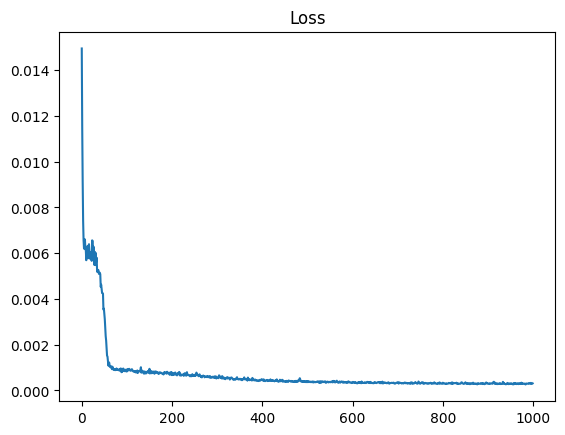

0.0018037008828416998


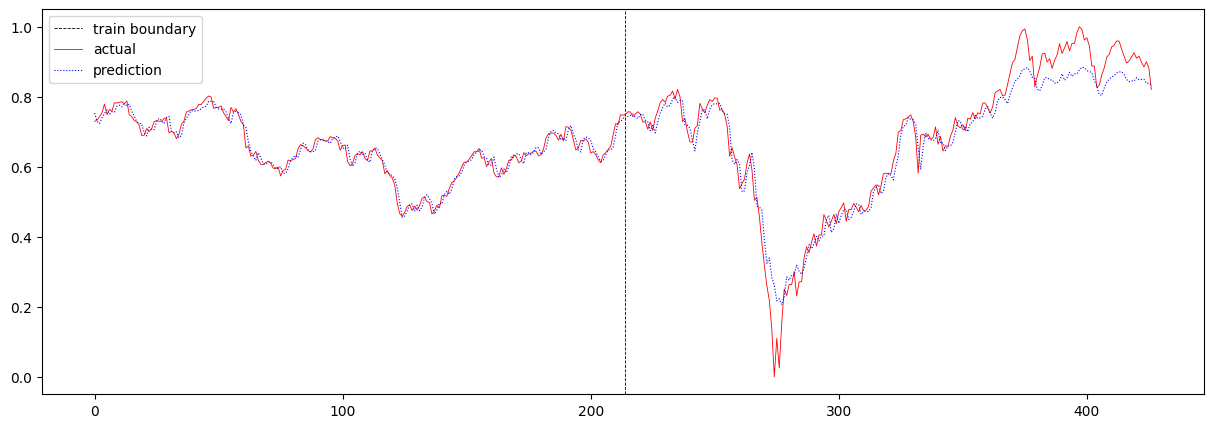

In [17]:
batch_size = 64
test_ratio = 0.5
sequence_length = 4
train_dataset, test_dataset, train_loader, test_loader = build_data(
    x, y, batch_size, test_ratio, sequence_length
)

model = VanillaRNN(
    input_size=5,
    hidden_size=8,
    output_size=1,
    seq_len=sequence_length,
    num_layers=2,
    nonlinearity="tanh",
    device=device,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(model, criterion, optimizer, train_loader, num_epochs=1000)
test(model, criterion, train_dataset, test_dataset, sequence_length, batch_size)


[+] train len: 208, test len: 207
[Epoch: 99] loss: 0.0018
[Epoch: 199] loss: 0.0014
[Epoch: 299] loss: 0.0011
[Epoch: 399] loss: 0.0009
[Epoch: 499] loss: 0.0005
[Epoch: 599] loss: 0.0004
[Epoch: 699] loss: 0.0003
[Epoch: 799] loss: 0.0003
[Epoch: 899] loss: 0.0003
[Epoch: 999] loss: 0.0003


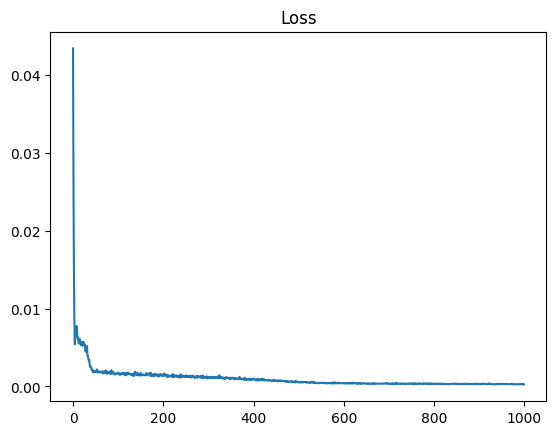

0.003558426051833002


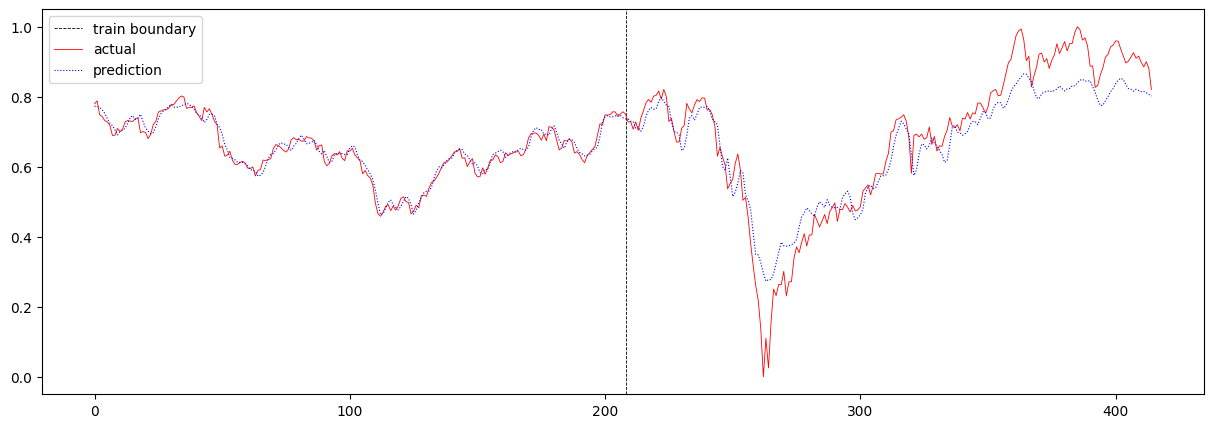

In [13]:
batch_size = 64
test_ratio = 0.5
sequence_length = 16
train_dataset, test_dataset, train_loader, test_loader = build_data(
    x, y, batch_size, test_ratio, sequence_length
)

model = VanillaRNN(
    input_size=5,
    hidden_size=8,
    output_size=1,
    seq_len=sequence_length,
    num_layers=2,
    nonlinearity="tanh",
    device=device,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(model, criterion, optimizer, train_loader, num_epochs=1000)
test(model, criterion, train_dataset, test_dataset, sequence_length, batch_size)


[+] train len: 200, test len: 199
[Epoch: 99] loss: 0.0008
[Epoch: 199] loss: 0.0007
[Epoch: 299] loss: 0.0006
[Epoch: 399] loss: 0.0004
[Epoch: 499] loss: 0.0004
[Epoch: 599] loss: 0.0004
[Epoch: 699] loss: 0.0003
[Epoch: 799] loss: 0.0003
[Epoch: 899] loss: 0.0004
[Epoch: 999] loss: 0.0003


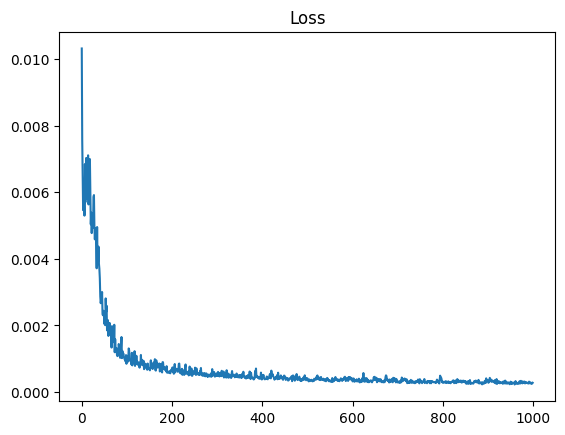

0.0036208713406397563


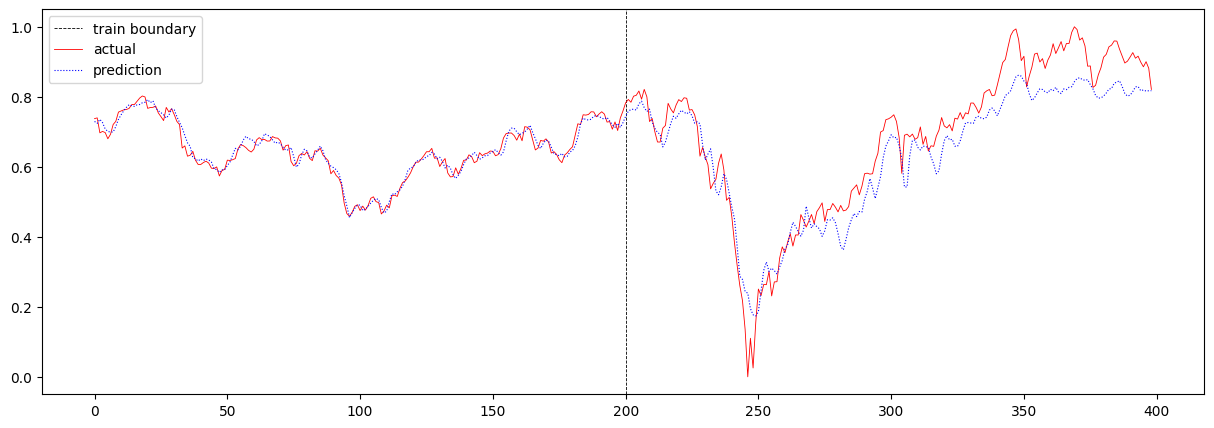

In [14]:
batch_size = 64
test_ratio = 0.5
sequence_length = 32
train_dataset, test_dataset, train_loader, test_loader = build_data(
    x, y, batch_size, test_ratio, sequence_length
)

model = VanillaRNN(
    input_size=5,
    hidden_size=8,
    output_size=1,
    seq_len=sequence_length,
    num_layers=2,
    nonlinearity="tanh",
    device=device,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(model, criterion, optimizer, train_loader, num_epochs=1000)
test(model, criterion, train_dataset, test_dataset, sequence_length, batch_size)


[+] train len: 200, test len: 199
[Epoch: 99] loss: 0.0008
[Epoch: 199] loss: 0.0005
[Epoch: 299] loss: 0.0003
[Epoch: 399] loss: 0.0003
[Epoch: 499] loss: 0.0002
[Epoch: 599] loss: 0.0002
[Epoch: 699] loss: 0.0003
[Epoch: 799] loss: 0.0002
[Epoch: 899] loss: 0.0002
[Epoch: 999] loss: 0.0002


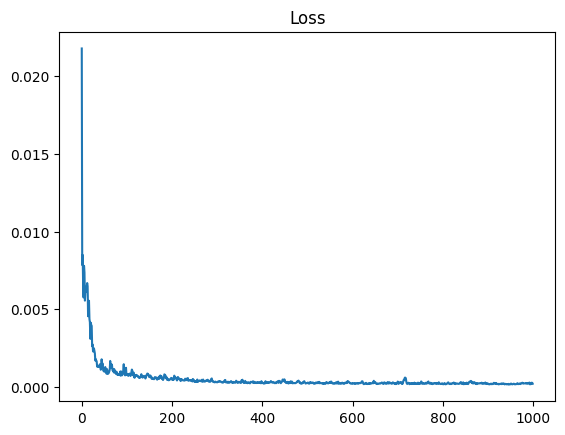

0.005664576799192998


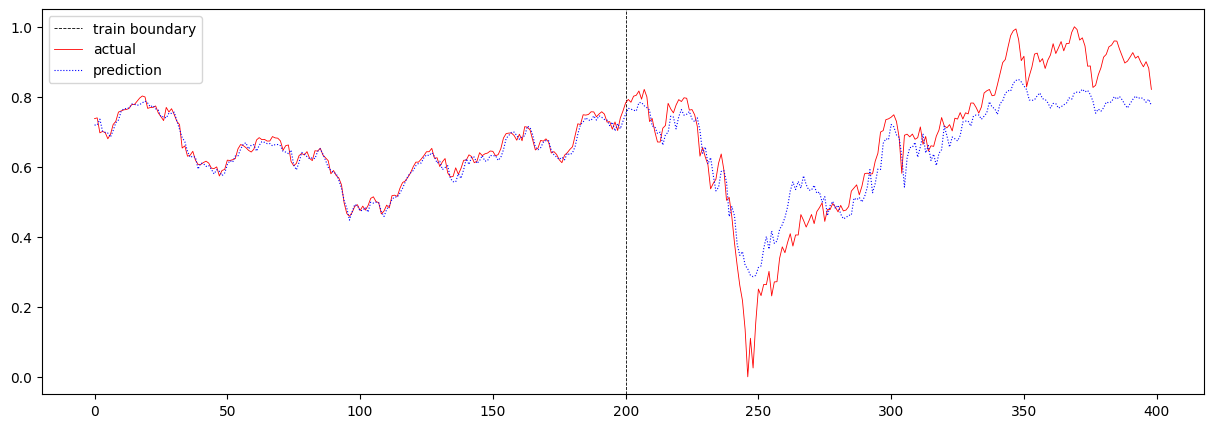

In [15]:
batch_size = 64
test_ratio = 0.5
sequence_length = 32
train_dataset, test_dataset, train_loader, test_loader = build_data(
    x, y, batch_size, test_ratio, sequence_length
)

model = VanillaRNN(
    input_size=5,
    hidden_size=16,
    output_size=1,
    seq_len=sequence_length,
    num_layers=4,
    nonlinearity="tanh",
    device=device,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(model, criterion, optimizer, train_loader, num_epochs=1000)
test(model, criterion, train_dataset, test_dataset, sequence_length, batch_size)
